##**Import all Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
import zipfile

## **Mount Google Drive and Load Augmented Images**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzip the Test dataset to data final

with zipfile.ZipFile('/content/drive/MyDrive/ML Project/Augmentation3.zip','r') as zip_ref:
  zip_ref.extractall('data final')

## **Validation and Test Data Split with Resizing**

In [4]:
data_dir = '/content/data final/augmented_images3/training_set'
img_size = 224
bach_size = 32
# Training and validation dataset split
train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         seed = 123,
                                                         validation_split = 0.2,
                                                         subset = 'training',
                                                         label_mode = 'categorical',
                                                         batch_size = bach_size,
                                                         image_size = (img_size, img_size))
val_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         seed = 123,
                                                         validation_split = 0.2,
                                                         subset = 'validation',
                                                         label_mode = 'categorical',
                                                         batch_size = bach_size,
                                                         image_size = (img_size, img_size))

Found 3387 files belonging to 5 classes.
Using 2710 files for training.
Found 3387 files belonging to 5 classes.
Using 677 files for validation.


## **ResNet50 Pretrained Model, Two More Dense layers With L2 Reguralization and Dropout Layer**

In [5]:
# Load ResNet50 model pretrained on ImageNet, without top layers
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,  # Exclude the final classification layer
    input_shape=(224, 224, 3),  # Input size
    weights='imagenet'  # Use pretrained weights on ImageNet
)

# Freeze the base model
resnet_model.trainable = False

# Add classification layers on top of the base model
model = models.Sequential([

    resnet_model,

    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                 input_shape=(224, 224, 3)),

    layers.Dropout(0.5),

    layers.Dense(5, activation='softmax',kernel_regularizer=regularizers.l2(0.01))  # Assuming you have 5 classes
])

94765736/94765736 [==============================] - 0s 0us/step


## **Learning Rate Scheduler and Early Stopping methods**

In [6]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,  # Number of epochs with no improvement before reducing LR
    min_lr=1e-7  # Lower bound on the learning rate
)

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping (
                                                    monitor="val_accuracy",
                                                    min_delta=0.01,
                                                    patience=5,
                                                    verbose=1
                                                  )

### **Model Checkpoint**

In [8]:
model_cps = tf.keras.callbacks.ModelCheckpoint (
                                                  filepath = "/content/drive/MyDrive/ML Project/ResNet_Model.keras",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  save_weights_only=False,

                                               )

## **Compilation and training**

In [10]:
# Compile the model - tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [11]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_cps,early_stopping,lr_scheduler]
)

Epoch 1/20
85/85 [==============================] - ETA: 0s - loss: 8.3850 - accuracy: 0.4295
Epoch 1: val_accuracy improved from -inf to 0.51256, saving model to /content/drive/MyDrive/ML Project/ResNet_Model.keras
85/85 [==============================] - 63s 702ms/step - loss: 8.3850 - accuracy: 0.4295 - val_loss: 4.2118 - val_accuracy: 0.5126 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - ETA: 0s - loss: 3.1984 - accuracy: 0.5107
Epoch 2: val_accuracy did not improve from 0.51256
85/85 [==============================] - 56s 663ms/step - loss: 3.1984 - accuracy: 0.5107 - val_loss: 2.4853 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - ETA: 0s - loss: 2.1423 - accuracy: 0.5203
Epoch 3: val_accuracy improved from 0.51256 to 0.55835, saving model to /content/drive/MyDrive/ML Project/ResNet_Model.keras
85/85 [==============================] - 57s 668ms/step - loss: 2.1423 - accuracy: 0.5203 - val_loss: 1.8784 - val_accuracy: 0.558

## **Model Performance Evaluation**

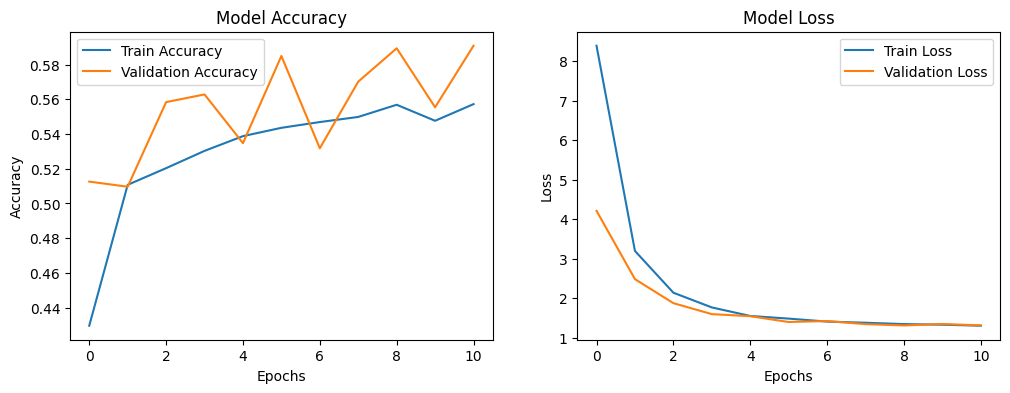

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Prediction On Test Data**

In [13]:
testdata_dir = '/content/drive/MyDrive/ML Project/Test_Data/TestImages'
test_set = tf.keras.utils.image_dataset_from_directory(testdata_dir,
                                                       label_mode=None, #Ensures that the test set is loaded without any lables
                                                        batch_size = bach_size,
                                                        image_size = (img_size, img_size),
                                                        shuffle=False # To keep the order in which the image is loaded
                                                       )
image_ids = sorted([f for f in os.listdir(testdata_dir) if os.path.isfile(os.path.join(testdata_dir, f))])

Found 478 files belonging to 1 classes.


In [14]:
# Get the list of all file names (image IDs without extension)
image_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(testdata_dir) if os.path.isfile(os.path.join(testdata_dir, f))])

# Make predictions on the test dataset
predictions = model.predict(test_set)

# Convert logits to predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Mapping class indices (0,1,2,3,4) to (A,B,C,D,S) -> (1,2,3,4,5)
class_mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
mapped_predictions = [class_mapping[i] for i in predicted_classes]

# Create a DataFrame to store image IDs and predictions
df = pd.DataFrame({
    'ID': image_ids,  # Using the actual image ID without .jpg extension
    'Prediction': mapped_predictions
})

# Export the DataFrame to a CSV file
df.to_csv('submissions.csv', index=False)

print("Predictions saved to .csv")

15/15 [==============================] - 11s 569ms/step
Predictions saved to .csv
